# Population Basics

This notebook demonstrates an example workflow for creating a sample population manually. In most applications this is not required (you are more likelly to inject a travel diary or a MATSim plans file)but the exercide is useful to understand the underlying data structure.

### The Core Objects

pam populations are built from three core objects:

`Population`, `Household` and `Person` objects. Persons belong to a `Household` and households belong to a `Population`. This relationship can be created using the `Population.add` and `Household.add` methods.

Note that `Household` and `Person` objects require unique identifiers. households require a `hid` (household id) and persons a `pid` (person id).

Households and Persons can also be given attributes as a simple dictionary. Attributes can include useful features such as income or car ownership.

In [1]:
from pam.core import Population, Household, Person

population = Population()  # initialise an empty population

household = Household(
    hid=0,
    attributes={"cars": 1}
    )

person = Person(
    pid=0,
    attributes={"income": "medium"}
    )

household.add(person)
population.add(household)

population.stats

{'num_households': 1, 'num_people': 1, 'num_activities': 0, 'num_legs': 0}

### Activity Plans (or "Sequences")

`Person` activity plans are held by the `pam.activity.Plan` object. All Persons have a `Plan`, even if it is empty. A `Plan` is simply a sequence of `Activity` and `Trip` (or `Leg`if you prefer - they are equivalent) objects.

Plans must start and end with an `Activity` and the two objects must alternate, for example; `Activity("home")`, `Trip()`, `Activity("work")`, `Trip()`, `Activity("home")`.

Both Activities and Trips can have start and end times (using datetime objects). Activities have locations whereas Trips have start and end locations. When manually creating your own sequences care should be taken to make these times and locations consistent. Such that, for example, a trip ends when the next activity starts and a trip start is at the same location as the preceding activity.

Activities are expected to have a type, for example, `'work'` or `'golf'`. Trips are expected to have a mode, for example `'car'` etc. These examples generally use strings for these features but this is not a requirement.

In [2]:
from pam.activity import Activity, Trip
from pam.utils import minutes_to_datetime as mtdt

activity = Activity(
    act='home',
    area="A",
    start_time=mtdt(0),
    end_time=mtdt(445)
)

trip = Trip(
    mode='car',
    start_area="A",
    end_area="B",
    start_time=mtdt(445),
    end_time=mtdt(505)
)

print(activity)
print(trip)

Activity(act:home, location:A, time:00:00:00 --> 07:25:00, duration:7:25:00)
Leg(mode:car, area:A --> B, time:07:25:00 --> 08:25:00, duration:1:00:00)


Activities and Trips can be added to a Person object using `Person.add`:

In [3]:
person = Person(pid=0, attributes={"type": "example"})

person.add(Activity(
    act='home',
    area="A",
    start_time=mtdt(0),
    end_time=mtdt(445)
))
person.add(Trip(
    mode='car',
    start_area="A",
    end_area="B",
    start_time=mtdt(445),
    end_time=mtdt(505)
))
person.add(Activity(
    act='hotel',
    area="B",
    start_time=mtdt(505),
    end_time=mtdt(1000)
))

person.validate()  # the validate method check for consistency in the sequence of locations and times
person.print()

Person: 0
{'type': 'example'}
0:	Activity(act:home, location:A, time:00:00:00 --> 07:25:00, duration:7:25:00)
1:	Leg(mode:car, area:A --> B, time:07:25:00 --> 08:25:00, duration:1:00:00)
2:	Activity(act:hotel, location:B, time:08:25:00 --> 16:40:00, duration:8:15:00)


### Locations

Pam uses `pam.location.Location` objects to keep track of `Activity` and `Trip` locations.

These locations can be any combination of `area` or `loc` or `link`. Area is assumed to be spatial zone id, for example, "City of London".

`Loc` must be a coordinate (using a `shapely.geometry.Point`). `Link` is a network id. Locs and Links are only required for specific applications such as MATSim and can be added or sampled later, so are not covered further here.

In [4]:
from shapely.geometry import Point

person = Person(pid=0, attributes={"type": "example"})

person.add(Activity(
    act='home',
    area="A",
    loc=Point((0,0)),
    start_time=mtdt(0),
    end_time=mtdt(445)
))
person.add(Trip(
    mode='car',
    start_area="A",
    end_area="B",
    start_loc=Point((0,0)),
    end_loc=Point((1234,1234)),
    start_time=mtdt(445),
    end_time=mtdt(505)
))
person.add(Activity(
    act='hotel',
    area="B",
    start_time=mtdt(505),
    end_time=mtdt(1000)
))

person.validate()  # the validate method check for consistency in the sequence of locations and times
person.print()

Person: 0
{'type': 'example'}
0:	Activity(act:home, location:POINT (0 0), time:00:00:00 --> 07:25:00, duration:7:25:00)
1:	Leg(mode:car, area:POINT (0 0) --> POINT (1234 1234), time:07:25:00 --> 08:25:00, duration:1:00:00)
2:	Activity(act:hotel, location:B, time:08:25:00 --> 16:40:00, duration:8:15:00)


### All Togther Now

Pam has read methods for common travel diary data formats and for MATSim. We are also creating simple tour based generators, for example for freight. But below we show how you might create a completely synthetic population from scratch.

Note that for conveneince the `add` methods will also try to unpack lists.

In [5]:
population = Population()  # create a new empty population

In [6]:
the_smiths = Household("Smiths")

tom = Person("Tom", attributes = {"age": "low"})
tammy = Person("Tammy", attributes = {"age": "low"})
the_smiths.add([tom, tammy])

population.add(the_smiths)  # and add the household to the population

tammy.add([
    Activity(
        act='home',
        area="A",
        loc=Point((0,0)),
        start_time=mtdt(0),
        end_time=mtdt(445)
    ),
    Trip(
        mode='car',
        start_area="A",
        end_area="B",
        start_loc=Point((0,0)),
        end_loc=Point((1234,1234)),
        start_time=mtdt(445),
        end_time=mtdt(505)
    ),
    Activity(
        act='work',
        area="B",
        loc=Point((1233,1234)),
        start_time=mtdt(505),
        end_time=mtdt(990)
    ),
    Trip(
        mode='car',
        start_area="B",
        end_area="A",
        start_loc=Point((1234,1234)),
        end_loc=Point((0,0)),
        start_time=mtdt(990),
        end_time=mtdt(1050)
    ),
    Activity(
        act='home',
        area="A",
        loc=Point((0,0)),
        start_time=mtdt(1050),
        end_time=mtdt(24*60)  # assuming a 24 hour day
    )
])

tom.add([
    Activity(
        act='home',
        area="A",
        loc=Point((0,0)),
        start_time=mtdt(0),
        end_time=mtdt(24*60)  # assuming a 24 hour day
    )
])

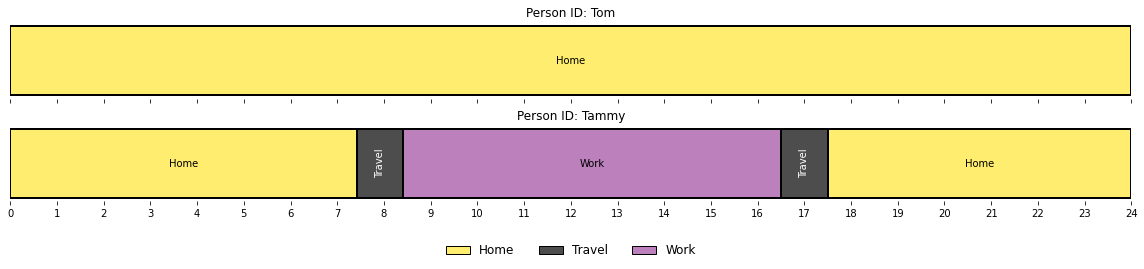

In [7]:
the_smiths.plot()

In [8]:
milkman = Person(0, attributes = {"bot": "yes", "electric vehicle": "yes"})

population.add(milkman)  # adding a person directly to the population is possible but a household with the same id will be auto generated

milkman.add([
    Activity(
        act='depot',
        area="A",
        loc=Point((0,0)),
        start_time=mtdt(0),
        end_time=mtdt(300)
    ),
    Trip(
        mode='car',
        start_area="A",
        end_area="A",
        start_loc=Point((0,0)),
        end_loc=Point((1000,1000)),
        start_time=mtdt(300),
        end_time=mtdt(310)
    ),
    Activity(
        act='delivery',
        area="A",
        loc=Point((1000,1000)),
        start_time=mtdt(310),
        end_time=mtdt(320)
    ),
    Trip(
        mode='car',
        start_area="A",
        end_area="A",
        start_loc=Point((1000,1000)),
        end_loc=Point((0,1000)),
        start_time=mtdt(320),
        end_time=mtdt(330)
    ),
    Activity(
        act='delivery',
        area="A",
        loc=Point((0,1000)),
        start_time=mtdt(330),
        end_time=mtdt(340)
    ),
    Trip(
        mode='car',
        start_area="A",
        start_loc=Point((0,1000)),
        end_loc=Point((0,0)),
        end_area="A",
        start_time=mtdt(340),
        end_time=mtdt(350)
    ),
    Activity(
        act='depot',
        area="A",
        loc=Point((0,0)),
        start_time=mtdt(350),
        end_time=mtdt(24*60)  # assuming a 24 hour day
    )
])

('Directly adding a Person to a Population requires a Household.', 'Auto creating a household 0 for person 0, check this is intended.')


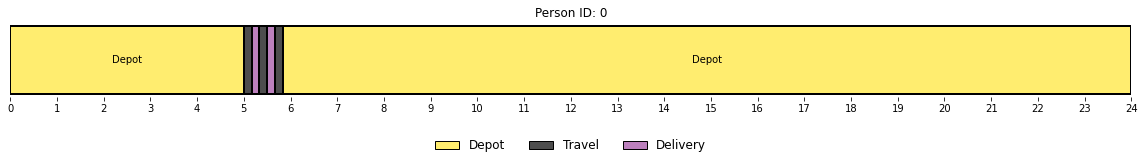

In [9]:
milkman.plot()

In [10]:
population.print()

Population: 3 people in 2 households.
Household: Smiths
{}
Person: Tom
{'age': 'low'}
0:	Activity(act:home, location:POINT (0 0), time:00:00:00 --> 00:00:00, duration:1 day, 0:00:00)
Person: Tammy
{'age': 'low'}
0:	Activity(act:home, location:POINT (0 0), time:00:00:00 --> 07:25:00, duration:7:25:00)
1:	Leg(mode:car, area:POINT (0 0) --> POINT (1234 1234), time:07:25:00 --> 08:25:00, duration:1:00:00)
2:	Activity(act:work, location:POINT (1233 1234), time:08:25:00 --> 16:30:00, duration:8:05:00)
3:	Leg(mode:car, area:POINT (1234 1234) --> POINT (0 0), time:16:30:00 --> 17:30:00, duration:1:00:00)
4:	Activity(act:home, location:POINT (0 0), time:17:30:00 --> 00:00:00, duration:6:30:00)
Household: 0
{}
Person: 0
{'bot': 'yes', 'electric vehicle': 'yes'}
0:	Activity(act:depot, location:POINT (0 0), time:00:00:00 --> 05:00:00, duration:5:00:00)
1:	Leg(mode:car, area:POINT (0 0) --> POINT (1000 1000), time:05:00:00 --> 05:10:00, duration:0:10:00)
2:	Activity(act:delivery, location:POINT (10

### Export

Exports plans to csv or xml format for MATSim.

In [11]:
from pam.write.diary import to_csv

to_csv(population=population, dir="tmp")

Missing person weight in hh Smiths, returning None.
Missing person weight in hh 0, returning None.


In [12]:
from pam.write import write_matsim

write_matsim(population=population, plans_path="tmp/plans.xml")